# 06 Antialiasing - Numpy broadcasting

* 기존 예제에서 for loop을 제거하고 Numpy의 broadcasting을 이용하여 가속한 예제입니다.
* GPU를 사용하는 Pytorch 등으로 쉽게 치환할 수 있고 더욱 빨라집니다.

In [1]:
from __future__ import annotations

from typing import List
import sys

import numpy as np
import numpy.linalg as LA

import matplotlib.pyplot as plt

infinity = sys.float_info.max

In [2]:
def normalize(vec: np.array, eps: float = 1e-6):
    return vec / (LA.norm(vec, axis=-1, keepdims=True) + eps)


def blend(color1: np.array, color2: np.array, t_map: np.array):
    return (1.0 - t_map) * color1 + t_map * color2


def dot(v1: np.array, v2: np.array) -> np.array:
    return np.sum(v1 * v2, axis=-1, keepdims=True)


def normalize_color(image: np.array, samples_per_pixel: int):
    # divide the color by the number of samples.
    scale = 1.0 / samples_per_pixel
    return scale * image

In [3]:
class Ray:
    def __init__(self, origin: np.array, direction_map: np.array) -> None:
        self.origin = origin
        self.direction_map = normalize(direction_map)
        self.height, self.width = self.direction_map.shape[:2]

    def at(self, t_map: np.array) -> np.array:
        return self.origin + t_map * self.direction_map

In [4]:
class HitRecord:
    def __init__(
        self,
        point_map: np.array,
        normal_map: np.array,
        t_map: np.array,
        valid_map: np.array,
    ) -> None:
        self.point_map = point_map
        self.normal_map = normal_map
        self.t_map = t_map
        self.valid_map = valid_map

    def set_face_normal(self, ray: Ray, outward_normal_map: np.array) -> None:
        is_front_face = dot(ray.direction_map, outward_normal_map) < 0.0
        self.normal_map = np.where(
            is_front_face, outward_normal_map, -outward_normal_map
        )

    def update(self, other: HitRecord) -> None:
        self.point_map = np.where(other.valid_map, other.point_map, self.point_map)
        self.normal_map = np.where(other.valid_map, other.normal_map, self.normal_map)
        self.t_map = np.where(other.valid_map, other.t_map, self.t_map)
        self.valid_map = np.where(other.valid_map, other.valid_map, self.valid_map)

In [5]:
class Hittable:
    def hit(self, ray: Ray, t_min_map: float, t_max_map: float) -> HitRecord:
        raise NotImplementedError

In [6]:
class Sphere(Hittable):
    def __init__(self) -> None:
        self.center = np.zeros(3)
        self.radius = 1.0

    def __init__(self, center: np.array, radius: float) -> None:
        self.center = center
        self.radius = radius

    def hit(self, ray: Ray, t_min_map: float, t_max_map: float) -> bool:
        dir_center_to_origin = ray.origin - self.center

        a_map = dot(ray.direction_map, ray.direction_map)
        half_b_map = dot(dir_center_to_origin, ray.direction_map)
        c_map = dot(dir_center_to_origin, dir_center_to_origin) - self.radius**2.0

        discriminant_map = half_b_map**2 - a_map * c_map
        cond_discriminant = discriminant_map >= 0.0

        safe_discriminant_map = np.where(cond_discriminant, discriminant_map, 0.0)

        sqrt_d_map = np.sqrt(safe_discriminant_map)

        # find the nearest root that lies in the acceptable range.
        t_map1 = (-half_b_map - sqrt_d_map) / a_map
        cond1 = np.logical_and(t_min_map <= t_map1, t_map1 <= t_max_map)
        t_map2 = (-half_b_map + sqrt_d_map) / a_map
        cond2 = np.logical_and(t_min_map <= t_map2, t_map2 <= t_max_map)

        valid_map = np.logical_and(cond_discriminant, np.logical_or(cond1, cond2))

        t_map = np.where(cond1, t_map1, t_map2)

        point_map = ray.at(t_map)
        outward_normal_map = (point_map - self.center) / self.radius
        hit_record = HitRecord(
            point_map=point_map,
            normal_map=outward_normal_map,
            t_map=t_map,
            valid_map=valid_map,
        )
        hit_record.set_face_normal(ray=ray, outward_normal_map=outward_normal_map)
        return hit_record

In [7]:
class HittableList(Hittable):
    def __init__(self) -> None:
        self.objects: List[Hittable] = []

    def clear(self) -> None:
        self.objects.clear()

    def add(self, object: Hittable) -> None:
        self.objects.append(object)

    def hit(self, ray: Ray, t_min_map: float, t_max_map: float) -> HitRecord:
        record = None
        closest_so_far_map = t_max_map

        for object in self.objects:
            tmp_record = object.hit(
                ray=ray, t_min_map=t_min_map, t_max_map=closest_so_far_map
            )
            closest_so_far_map = np.where(
                tmp_record.valid_map, tmp_record.t_map, closest_so_far_map
            )
            if record is None:
                record = tmp_record
            else:
                record.update(tmp_record)

        return record

In [8]:
class Camera:
    def __init__(self) -> None:
        self.aspect_ratio = 16.0 / 9.0
        self.viewport_height = 2.0
        self.viewport_width = self.aspect_ratio * self.viewport_height
        self.focal_length = 1.0

        self.origin = np.array([0.0, 0.0, 0.0])
        self.horizontal_vec = np.array([self.viewport_width, 0.0, 0.0])
        self.vertical_vec = np.array([0.0, self.viewport_height, 0.0])
        self.frontal_vec = np.array([0.0, 0.0, self.focal_length])
        self.lower_left_corner = (
            self.origin
            - self.horizontal_vec / 2.0
            - self.vertical_vec / 2.0
            - self.frontal_vec
        )

    def get_ray(self, u_map: float, v_map: float) -> Ray:
        return Ray(
            origin=self.origin,
            direction_map=(
                self.lower_left_corner
                + u_map * self.horizontal_vec
                + v_map * self.vertical_vec
            )
            - self.origin,
        )

In [9]:
def ray_color(ray: Ray, world: Hittable) -> np.array:
    record = world.hit(ray=ray, t_min_map=0, t_max_map=infinity)

    world_color = 0.5 * (record.normal_map + 1.0)

    t_map = 0.5 * (ray.direction_map[..., 1:2] + 1.0)
    color1 = np.array([1.0, 1.0, 1.0])
    color2 = np.array([0.5, 0.7, 1.0])
    background_color = blend(color1=color1, color2=color2, t_map=t_map)

    return np.where(record.valid_map, world_color, background_color)

In [10]:
# image
aspect_ratio = 16.0 / 9.0
image_width = 320
image_height = int(image_width / aspect_ratio)
samples_per_pixel = 10

In [11]:
# world
world = HittableList()
world.add(Sphere(center=np.array([0.0, 0.0, -1.0]), radius=0.5))
world.add(Sphere(center=np.array([0.0, -100.5, -1.0]), radius=100.0))

In [12]:
camera = Camera()

In [13]:
%%time

us = np.linspace(start=0.0, stop=1.0, num=image_width)
vs = np.linspace(start=0.0, stop=1.0, num=image_height)
u_map, v_map = np.meshgrid(us, vs, indexing="xy")
u_map = u_map[..., np.newaxis, np.newaxis]
v_map = v_map[..., np.newaxis, np.newaxis]

u_jitter = np.random.uniform(low=0.0, high=1.0/image_width, 
                             size=[image_height, image_width, samples_per_pixel, 1])
v_jitter = np.random.uniform(low=0.0, high=1.0/image_height, 
                             size=[image_height, image_width, samples_per_pixel, 1])

u_map = u_map + u_jitter
v_map = v_map + v_jitter
ray = camera.get_ray(u_map=u_map, v_map=v_map)     

image = ray_color(ray=ray, world=world)  
image = np.sum(image, axis=2)
image = normalize_color(image, samples_per_pixel=samples_per_pixel)

CPU times: total: 344 ms
Wall time: 343 ms


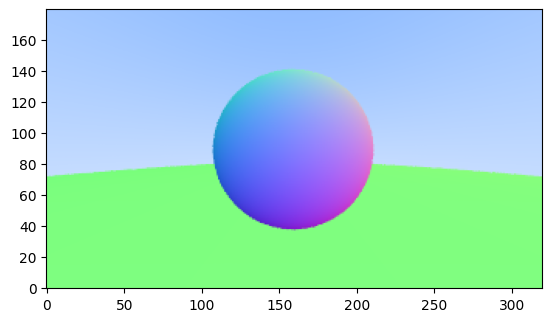

In [14]:
plt.imshow(image, origin="lower")
plt.show()